## 1D and 2D feature extraction

Instead of looking at scalar paremeters, we can instead look at more complex structures representing analyzed signals. We can create 1D structures using filtering, such as discrete wavelet transform, and then use these to extract other parameters or analyze directly using, for example, neural networks. We can also create 2D structures such as spectrograms and continuous wavelet transform graphs and use these in convolutional neural networks.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import h5py
import random
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import matplotlib.colors as colors
from scipy import signal
import pywt
import imageio


In [2]:
def get_sample(i):
    f=h5py.File("samples_full.hdf5","r")
    samp=f['Samples']
    time=f['Time']
    
    return samp[i,:],time[i]

In [4]:
f=h5py.File("samples_full.hdf5","r")
P=f['Samples']
T=f['Time']
N=len(T)

### Spectrograms

First, let's look at a spectrogram of a full time series, that is representing a whole experimental run data until the simulated earthquake. As it happens, one of them starts at index 37 and ends at index 331.

In [4]:
Ps=P[37]
ts=[T[37]]
for i in range(38,332):

    Ps=np.concatenate((Ps,P[i]),axis=None)
    ts.append(T[i])

4.4332575e-07 3401248.5


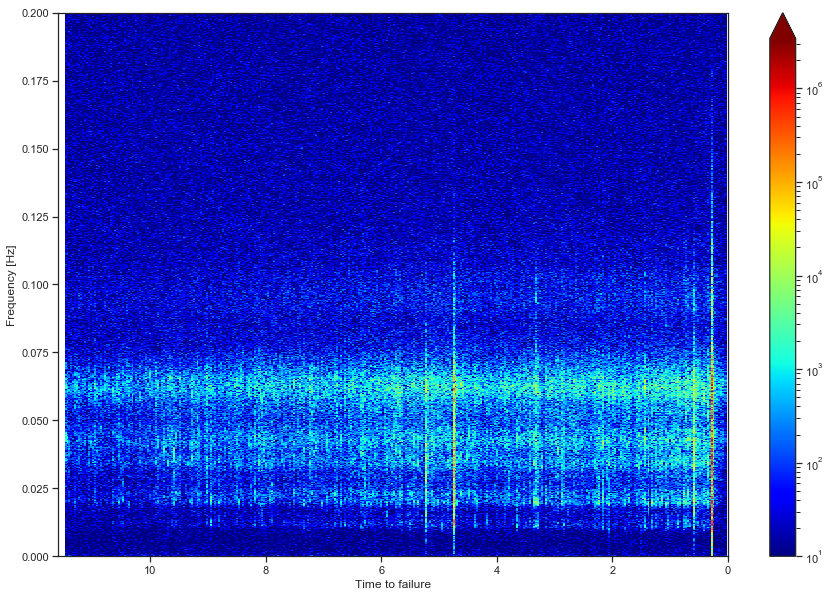

In [64]:
r, t, Sxx = signal.spectrogram(res,nperseg=150000) #nperseg represents number of data points per segment. Each segment chosen 
                                                   #here consists of 150000 data points, like our normal data series. In a
                                                   #spectrogram, FFT is applied to each segment and placed as a column.
t=np.multiply(t,11.455003/(t[-1]-t[0]))
t=t[::-1]
fig=plt.figure(figsize=(15,10))
ax=fig.add_subplot(111)
mesh=ax.pcolormesh(t, r, Sxx,cmap="jet",norm=colors.LogNorm(vmin=10, vmax=np.amax(Sxx)))
fig.colorbar(mesh, ax=ax, extend='max')
ax.set_ylabel('Frequency [Hz]')
ax.set_xlabel('Time to failure')
ax.set_ylim((0,0.2))
ax.set_xlim((T[37]+0.1,0))
print(np.amin(Sxx),np.amax(Sxx))

The spectrogram shows a lot of information. As we have seen previously by looking at power spectrum density, we see that the signal has several distinct frequencies, power in which increases in magnitude as the time progresses. We see that the magnitude increases drasticly ~0.2 before the event after which the signal has weaker frequency signatures, closer to what can be seen at T>10. 

However, if we want to predict how close we are to the event by looking at one signal, we should look at spectrograms of single time-series. In such case, we will choose 1000 points per segment, which should be a compromise between precision and generalization. Unlike in the previous, we will draw scale starting from 1, not 10. 

In [13]:
N_sample=4
Inds=np.random.choice(N,N_sample,replace=False)
P_sample=[]
T_sample=[]
for i in Inds:
    P_sample.append(P[i])
    T_sample.append(T[i])

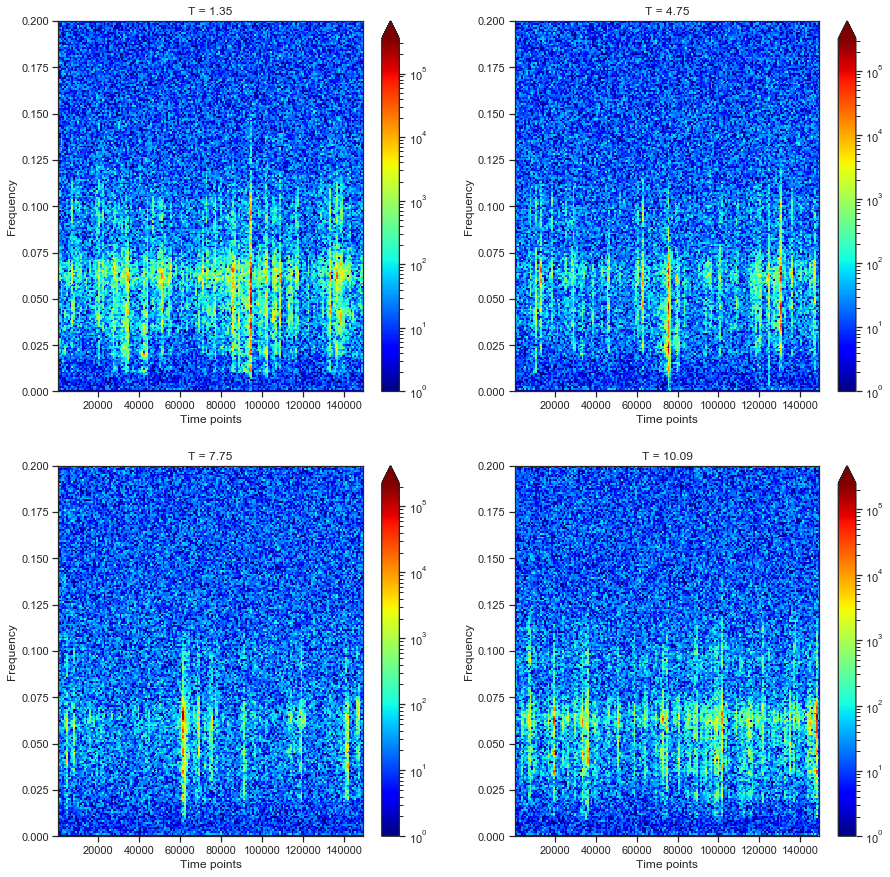

In [23]:
fig,ax=plt.subplots(2,2,figsize=(15,15))
ax=[ax[0,0],ax[0,1],ax[1,0],ax[1,1]]

for i in range(N_sample):
    
    r0, t0, Sxx0 = signal.spectrogram(P_sample[i],nperseg=1000)
    t0=t0[::-1]
    mesh0=ax[i].pcolormesh(t0, r0, Sxx0,cmap="jet",norm=colors.LogNorm(vmin=1, vmax=np.amax(Sxx0)))
    fig.colorbar(mesh0, ax=ax[i], extend='max')
    ax[i].set_ylabel('Frequency')
    ax[i].set_xlabel('Time points')
    ax[i].set_title('T = {:.2f}'.format(T_sample[i]))
    ax[i].set_ylim((0,0.2))


We can clearly see that the T=1.35 spectrogram shows much stronger signatures than other examples. We will now create images that could be saved and then analyzed. We will save the image as a 3-channel (RGB) 224x224 pixel matrix. We will also use the same scale for all the images.

Example of picture that will be saved (T=1.35)
Saved image shape is (224, 224, 3)


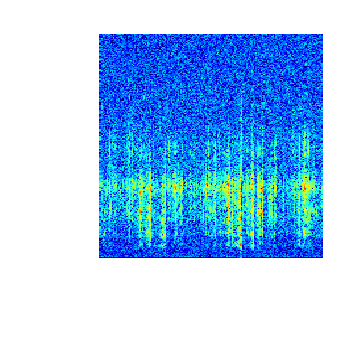

In [54]:
r1, t1, Sxx1 = signal.spectrogram(P_sample[0],nperseg=1000)
t1=t1[::-1]

#We have to remove fram and axis from the image
fig=plt.figure(figsize=(1,1),frameon=False,dpi=224) 
fig.subplots_adjust(bottom=0, top=1, left=0, right=1)
ax=fig.add_subplot(111)
ax.set_axis_off()

ax.pcolormesh(t1, r1, Sxx1,cmap="jet",norm=colors.LogNorm(vmin=1, vmax=3*10**5))

ax.axis('tight')
ax.set_ylim(0,0.2)


print('Example of picture that will be saved (T=1.35)')
fig.canvas.draw()  
    
image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

print("Saved image shape is {}".format(image.shape))

Create an hdf5 datafile without spectrograms saved. We don't want to keep them all in the memory.

In [32]:
ff=h5py.File("spectrs.hdf5","w")
Specs=ff.create_dataset('Spec',(len(T),224,224,3),dtype='uint8',chunks=(1,224,224,3),compression='gzip')
ff.create_dataset("Time",data=T)

<HDF5 dataset "Time": shape (14178,), type "<f4">

In [63]:
fig=plt.figure(figsize=(1,1),frameon=False,dpi=224)
fig.subplots_adjust(bottom=0, top=1, left=0, right=1)
ax=fig.add_subplot(111)
ax.set_axis_off()
temp=[]
for i in range(len(P)):
    
    #Saving to hdf5 file and flushing the memory
    if i%100==0 and i>0:
        temp=np.array(temp)
        Specs[i-100:i,:,:,:]=temp
        temp=[]
        ff.flush()
    
    #Drawing the image
    r1, t1, Sxx1 = signal.spectrogram(P[i],nperseg=1000)
    t1=t1[::-1]
    ax.pcolormesh(t1, r1, Sxx1,cmap="jet",norm=colors.LogNorm(vmin=1, vmax=np.amax(Sxx0)))
    ax.set_ylim((0,0.2))
    ax.set_axis_off()
    ax.axis('tight')
    fig.canvas.draw()  
    
    #Image matrix
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    temp.append(image)
    ax.clear()
    image=[]
    Sxx1=[]
    
plt.close()

print(Specs.shape)

ff.close()

(14178, 224, 224, 3)


### Continuous Wavelet Transform

Instead of creating spectrograms, we can create 2D images representing continuous wavelet transform. It is an operation that convolves the signal with a wavelet of choice of increasing frequency. The image will effectively show various frequency reactions at different point in the time series. Most commonly used choices for wavelets are derivatives of Gaussian curve. Here, let's look at "ricker" and a wavelet added to scipy.signal by hand - 4th derivative of Gaussian. These are chosen to look similar to wavelets obtained from the data signal.

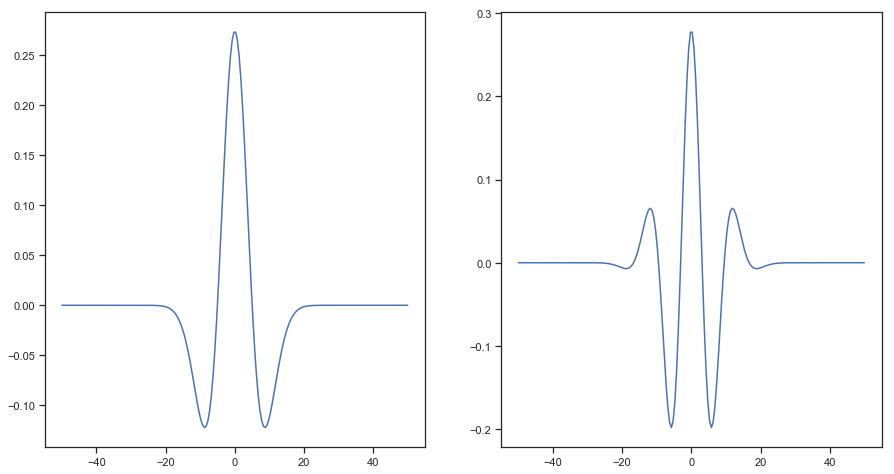

In [70]:
points=200
std=10
rng=np.linspace(-50,50,200)

fig=plt.figure(figsize=(15,8))
ax=fig.add_subplot(121)
ax.plot(rng,signal.ricker(points,std))


ax=fig.add_subplot(122)
ax.plot(rng,signal.herm_6(points,std))

Let's compare both transforms for the same signal (T=1.35) looked at before. We can plot log of the absolute value of the transform (which is a convolution) times the sign of the value, and use gaussian interpolation to obtain a smooth image. Color scheme was chosen to provide decent contrast.

In [71]:
 #Widths of the wavelet for which convolution is performed
widths_r = np.arange(100,21000,200)
widths_h = np.arange(100,25000,200)

Text(0.5, 0, 'Time points')

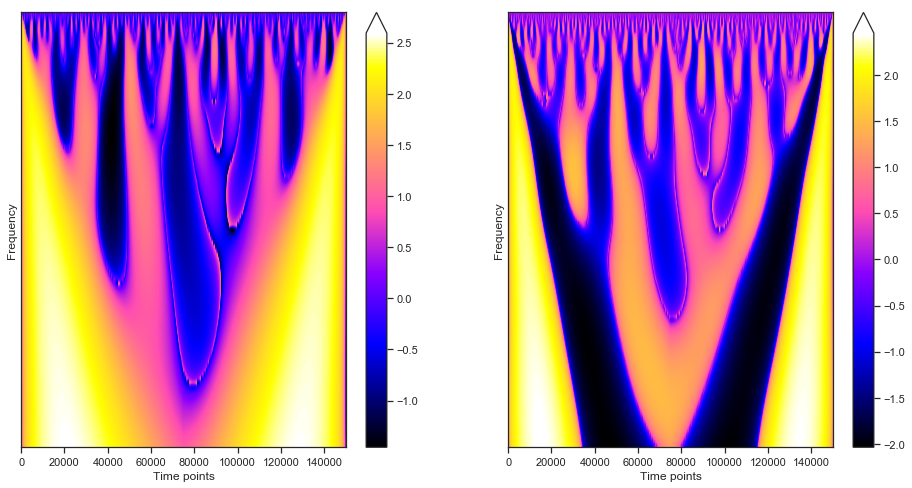

In [78]:
fig=plt.figure(figsize=(16,8))

cwtmatr = signal.cwt(P_sample[0], signal.ricker,widths_r)
ax=fig.add_subplot(121)
mesh=ax.imshow(np.sign(cwtmatr)*np.log10(np.absolute(cwtmatr)), interpolation="gaussian", extent=[0, 150000, max(widths_r), 0], cmap='gnuplot2', aspect='auto', vmin=-np.log10(abs(cwtmatr.min())), vmax=np.log10(abs(cwtmatr).max()))
fig.colorbar(mesh, ax=ax, extend='max')
ax.tick_params(axis='y',left=False)
ax.set_yticks([])
ax.set_ylabel('Frequency')
ax.set_xlabel('Time points')

cwtmatr = signal.cwt(P_sample[0], signal.herm_6,widths_h)
ax=fig.add_subplot(122)
mesh=ax.imshow(np.sign(cwtmatr)*np.log10(np.absolute(cwtmatr)), interpolation="gaussian", extent=[0, 150000, max(widths_r), 0], cmap='gnuplot2', aspect='auto', vmin=-np.log10(abs(cwtmatr.min())), vmax=np.log10(abs(cwtmatr).max()))
fig.colorbar(mesh, ax=ax, extend='max')
ax.tick_params(axis='y',left=False)
ax.set_yticks([])
ax.set_ylabel('Frequency')
ax.set_xlabel('Time points')

By looking at wavelets, we could already see that the "herm_6" wavelet would provide more detailed information about the signal. Indeed, the structure is richer. However, the "ricker" wavelet seems to provide slightly better contrast in mid-frequency regime. We will use it to create and save images. Let's compare transforms for different sample points. 

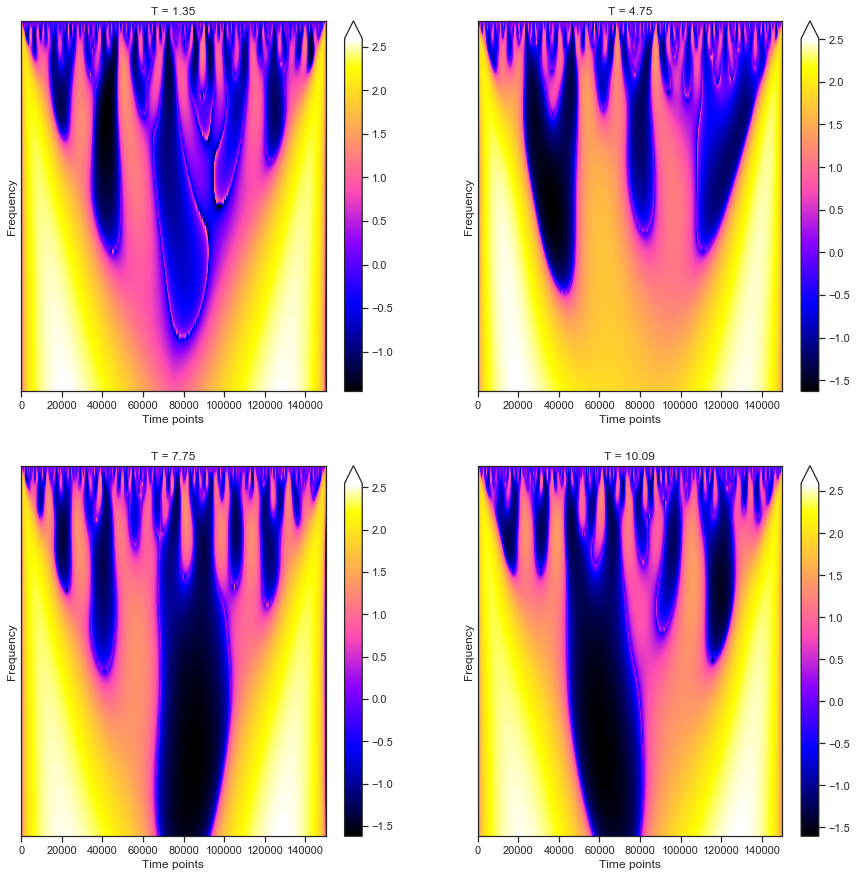

In [80]:
fig,ax=plt.subplots(2,2,figsize=(15,15))
ax=[ax[0,0],ax[0,1],ax[1,0],ax[1,1]]

for i in range(N_sample):
    
    cwtmatr = signal.cwt(P_sample[i], signal.ricker,widths_r)
    mesh=ax[i].imshow(np.sign(cwtmatr)*np.log10(np.absolute(cwtmatr)), interpolation="gaussian", extent=[0, 150000, max(widths_r), 0], cmap='gnuplot2', aspect='auto', vmin=-np.log10(abs(cwtmatr.min())), vmax=np.log10(abs(cwtmatr).max()))
    fig.colorbar(mesh, ax=ax[i], extend='max')
    ax[i].tick_params(axis='y',left=False)
    ax[i].set_yticks([])
    ax[i].set_ylabel('Frequency')
    ax[i].set_xlabel('Time points')
    ax[i].set_title('T = {:.2f}'.format(T_sample[i]))

Now, like with spectrograms, we will save these into an hdf5 file. First, let's test it.

Example of picture that will be saved (T=1.35)
Saved image shape is (224, 224, 3)


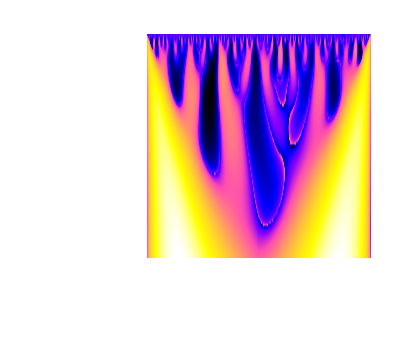

In [82]:
cwtmatr = signal.cwt(P_sample[0], signal.ricker,widths_r)

#We have to remove fram and axis from the image
fig=plt.figure(figsize=(1,1),frameon=False,dpi=224) 
fig.subplots_adjust(bottom=0, top=1, left=0, right=1)
ax=fig.add_subplot(111)
ax.set_axis_off()


ax.imshow(np.sign(cwtmatr)*np.log10(np.absolute(cwtmatr)), interpolation="gaussian", extent=[0, 150000, max(widths_r), 0], cmap='gnuplot2', aspect='auto', vmin=-np.log10(abs(cwtmatr.min())), vmax=np.log10(abs(cwtmatr).max()))
 
ax.axis('tight')

print('Example of picture that will be saved (T=1.35)')
fig.canvas.draw()  
    
image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

print("Saved image shape is {}".format(image.shape))

Like before, we loop over all time-series and create their CWT. We use the same scale for all of them. We also present some .gif animations showing how the CWT changes along the time series. They are included with the code.

In [83]:
ff=h5py.File("cwts.hdf5","w")
CWTs=ff.create_dataset('CWT',(len(T),224,224,3),dtype='uint8',chunks=(1,224,224,3),compression='gzip')
ff.create_dataset("Time",data=T)

<HDF5 dataset "Time": shape (14178,), type "<f4">

In [84]:
fig=plt.figure(figsize=(1,1),frameon=False,dpi=224)
fig.subplots_adjust(bottom=0, top=1, left=0, right=1)
ax=fig.add_subplot(111)
ax.set_axis_off()
temp=[]
for i in range(len(P)):
    
    #Saving to hdf5 file and flushing the memory
    if i%10==0 and i>0:
        temp=np.array(temp)
        CWTs[i-10:i,:,:,:]=temp
        temp=[]
        ff.flush()
    
    #Drawing the image
    cwtmatr = signal.cwt(P[i], signal.ricker,widths_r)
    ax.imshow(np.sign(cwtmatr)*np.log10(np.absolute(cwtmatr)), interpolation="gaussian", extent=[0, 150000, max(widths_r), 0], cmap='gnuplot2', aspect='auto', vmin=-1.75, vmax=2.75)
    
    ax.axis('tight')
    fig.canvas.draw()  
    
    #Image matrix
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    temp.append(image)
    ax.clear()
    image=[]
    cwtmatr=[]
    
plt.close()

print(CWTs.shape)

ff.close()

(14178, 224, 224, 3)


## Discrete wavelet transform

Discrete wavelet transform acts similarily to the continuous version - in convolves the time-series with wavelets of chosen sizes. It creates time-series that passes through through multiple low-pass filters with decreasing frequency. We use "ricker" wavelet for this transform as well. Let's test it on the T=1.35 data point. Low frequency part is at the top, highest frequency at the bottom.

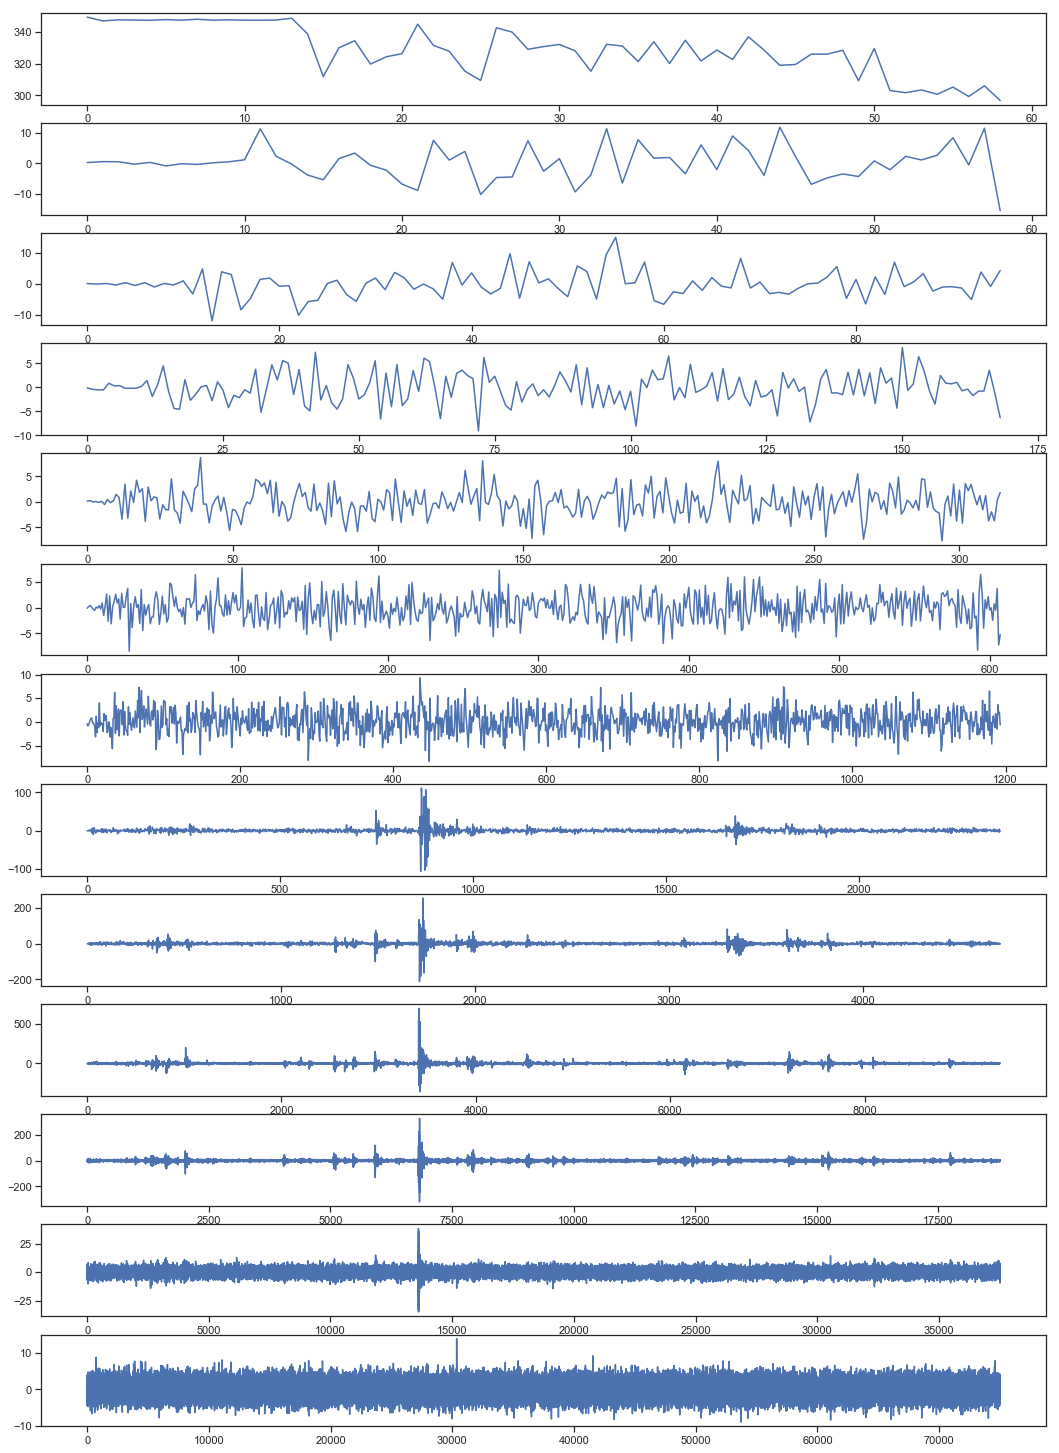

In [90]:
D=pywt.wavedec(P_sample[0],'coif4')

Wvs=len(D)

fig=plt.figure(figsize=(18,Wvs*2))
for i in range(Wvs):
    ax=fig.add_subplot(Wvs,1,i+1)
    ax.plot(D[i])

We do the same for a Daubechies wavelet.

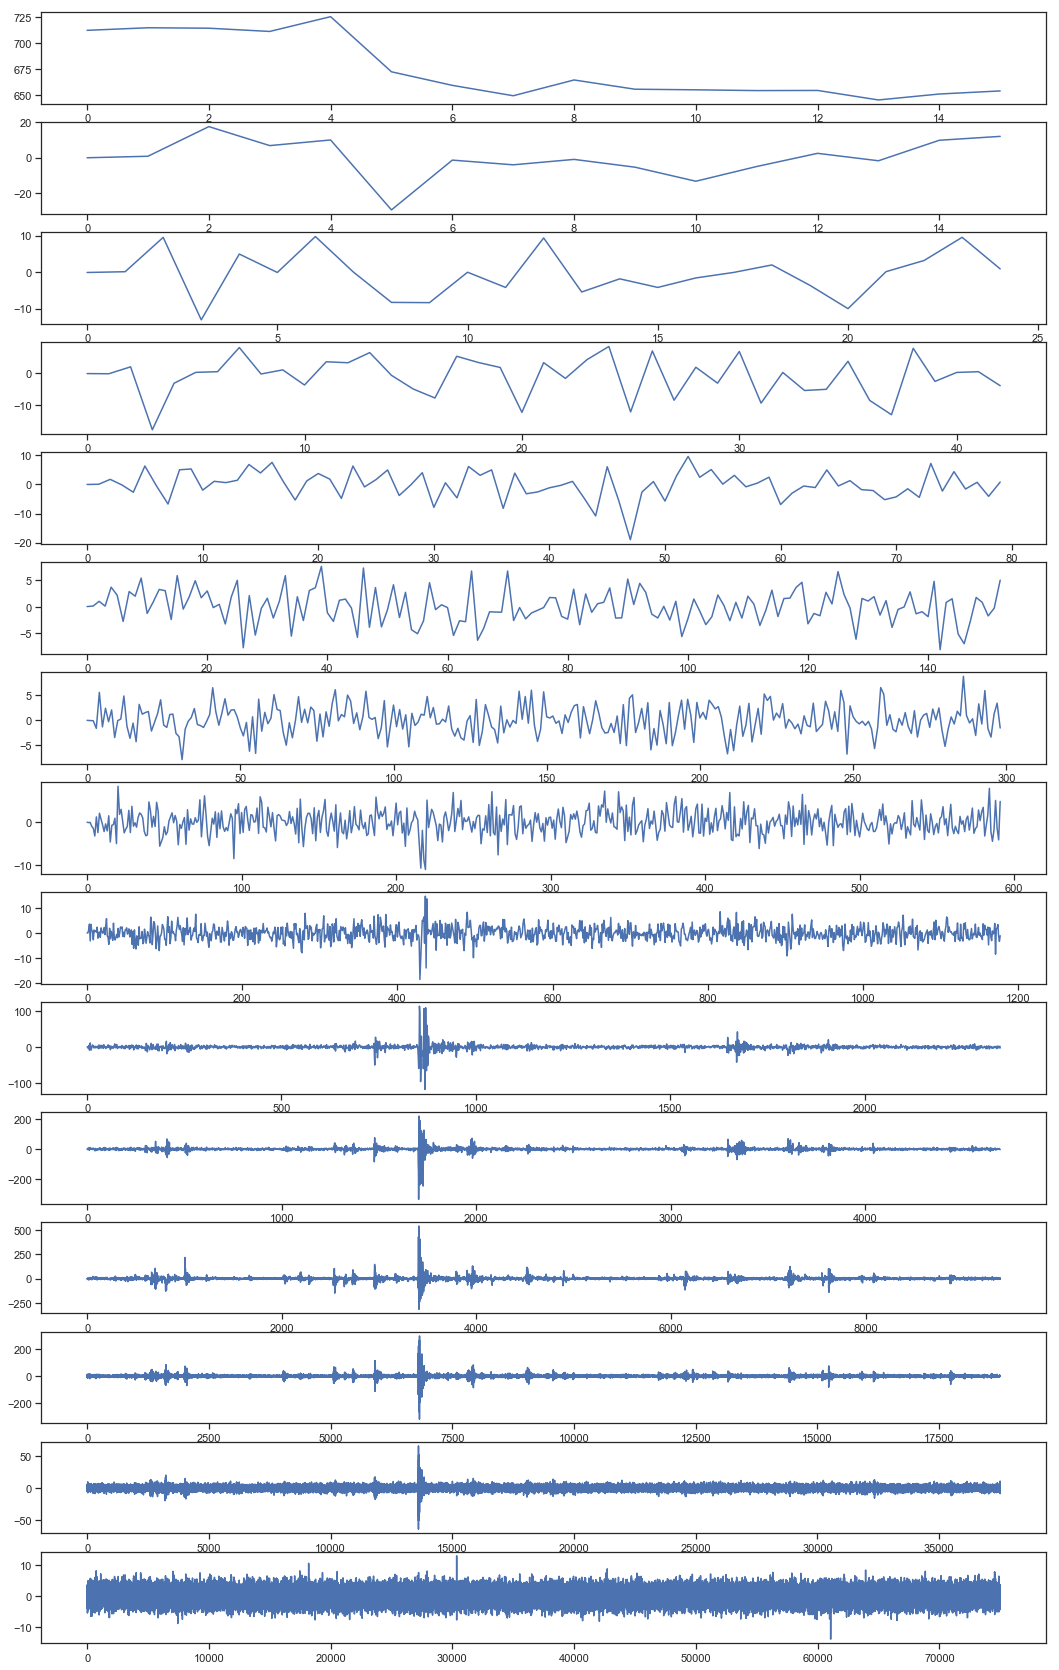

In [91]:
D=pywt.wavedec(P_sample[0],'db4')

Wvs=len(D)

fig=plt.figure(figsize=(18,Wvs*2))
for i in range(Wvs):
    ax=fig.add_subplot(Wvs,1,i+1)
    ax.plot(D[i])

There is no discerneable differenece. We also once again see that the mid-frequency regime carries most information. 